# Homework 1 - Professionalism & Reproducibility
# Name: James Joko (jjoko)
For reproducibility, execute each cell from top to bottom. The file "thank_the_academy.AUG.2023.csv" must be located in the same folder as this notebook

# Setup
Import the necessary modules we need for this homework. JSON for reading and storing API output, time for adding an artificial delay, urllib for URI encoding article titles, requests to make API requests, and pandas for reading the article dataset. We also load the article dataset into memory and define any constants we need for the API calls.

In [1]:
import json, time, urllib.parse, requests, pandas as pd

In [2]:
articles = pd.read_csv("thank_the_academy.AUG.2023.csv")
articles.head()

,name,url
0,Everything Everywhere All at Once,https://en.wikipedia.org/wiki/Everything_Every...
1,All Quiet on the Western Front (2022 film),https://en.wikipedia.org/wiki/All_Quiet_on_the...
2,The Whale (2022 film),https://en.wikipedia.org/wiki/The_Whale_(2022_...
3,Top Gun: Maverick,https://en.wikipedia.org/wiki/Top_Gun:_Maverick
4,Black Panther: Wakanda Forever,https://en.wikipedia.org/wiki/Black_Panther:_W...


In [6]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': 'jjoko@uw.edu, University of Washington, MSDS DATA 512 - AUTUMN 2023',
}

In [13]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response


# Step 1: Data Acquisition
## 1. Monthly Mobile Access
To calculate monthly mobile access I make two requests for each article, one for each access type of mobile. I then sum the two outputs, remove the access field, and return the output as {article_title: \<time series data\>}. Once this process has been executed on all articles in the dataset, I save the output to a JSON file and verify the files structure.

In [85]:
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "mobile-app",
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015060100",   # start and end dates need to be set
    "end":         "2023093024"    
}

def request_pageviews_per_article_mobile(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # Run a request for each mobile access type and store them
    mobile_access = ["mobile-app", "mobile-web"]
    json_response = []

    for access in mobile_access:
        request_template["access"] = access
        
        # now, create a request URL by combining the endpoint_url with the parameters for the request
        request_url = endpoint_url+endpoint_params.format(**request_template)

        # make the request
        try:
            # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
            # occurs during the request processing - throttling is always a good practice with a free
            # data source like Wikipedia - or other community sources
            if API_THROTTLE_WAIT > 0.0:
                time.sleep(API_THROTTLE_WAIT)
            response = requests.get(request_url, headers=headers)
            json_response.append(response.json())
        except Exception as e:
            print(e)
            return None
    # post-process the mobile json requests: sum the user counts, remove the access field
    for idx, item in enumerate(json_response[0]["items"]):
        del item["access"]
        item["views"] += json_response[1]["items"][idx]["views"]
    return {article_title: json_response[0]["items"]}

In [87]:
monthly_mobile = {}
for article_title in articles["name"]:
    print(article_title)
    monthly_mobile.update(request_pageviews_per_article_mobile(article_title))

Everything Everywhere All at Once
All Quiet on the Western Front (2022 film)
The Whale (2022 film)
Top Gun: Maverick
Black Panther: Wakanda Forever
Avatar: The Way of Water
Women Talking (film)
Guillermo del Toro's Pinocchio
Navalny (film)
The Elephant Whisperers
An Irish Goodbye
The Boy, the Mole, the Fox and the Horse (film)
RRR (film)
CODA (2021 film)
Dune (2021 film)
The Eyes of Tammy Faye (2021 film)
No Time to Die
The Windshield Wiper
The Long Goodbye (Riz Ahmed album)
The Queen of Basketball
Summer of Soul
Drive My Car (film)
Encanto
West Side Story (2021 film)
Belfast (film)
The Power of the Dog (film)
King Richard (film)
Cruella (film)
Nomadland (film)
The Father (2020 film)
Judas and the Black Messiah
Minari (film)
Mank
Sound of Metal
Ma Rainey's Black Bottom (film)
Promising Young Woman
Tenet (film)
Soul (2020 film)
Another Round (film)
My Octopus Teacher
Colette (2020 film)
If Anything Happens I Love You
Two Distant Strangers
Parasite (2019 film)
Ford v Ferrari
Learning to 

The Ghost and the Darkness
Kolya
The Nutty Professor (1996 film)
Quest (1996 film)
When We Were Kings
Breathing Lessons: The Life and Work of Mark O'Brien
Dear Diary (1996 film)
Braveheart
Apollo 13 (film)
Pocahontas (1995 film)
The Usual Suspects
Restoration (1995 film)
Babe (film)
Sense and Sensibility (film)
Il Postino: The Postman
Dead Man Walking (film)
Leaving Las Vegas
Mighty Aphrodite
Anne Frank Remembered
A Close Shave
Lieberman in Love
One Survivor Remembers
Antonia's Line
Toy Story
Forrest Gump
The Lion King
Speed (1994 film)
Ed Wood (film)
Pulp Fiction
Bullets Over Broadway
The Madness of King George
Legends of the Fall
A Time for Justice
Franz Kafka's It's a Wonderful Life
Maya Lin: A Strong Clear Vision
Burnt by the Sun
Trevor (film)
The Adventures of Priscilla, Queen of the Desert
Bob's Birthday
Blue Sky (1994 film)
Schindler's List
The Piano
Jurassic Park (film)
Philadelphia (film)
The Fugitive (1993 film)
The Age of Innocence (1993 film)
The Wrong Trousers
Belle Epoque

Cactus Flower (film)
Czechoslovakia 1968
It's Tough to Be a Bird
Oliver! (film)
The Lion in Winter (1968 film)
Romeo and Juliet (1968 film)
Funny Girl (film)
2001: A Space Odyssey (film)
Bullitt
The Producers (1967 film)
Rosemary's Baby (film)
The Subject Was Roses (film)
The Thomas Crown Affair (1968 film)
War and Peace (film series)
Charly
Journey into Self (1968 film)
Robert Kennedy Remembered
Why Man Creates
Winnie the Pooh and the Blustery Day
Planet of the Apes (1968 film)
In the Heat of the Night (film)
Camelot (film)
Bonnie and Clyde (film)
Guess Who's Coming to Dinner
Doctor Dolittle (1967 film)
The Graduate
Thoroughly Modern Millie
Cool Hand Luke
The Dirty Dozen
A Place to Stand (film)
The Anderson Platoon
The Box (1967 film)
Closely Watched Trains
The Redwoods
A Man for All Seasons (1966 film)
Who's Afraid of Virginia Woolf? (film)
Grand Prix (1966 film)
Fantastic Voyage
A Man and a Woman
Born Free
The Fortune Cookie
A Funny Thing Happened on the Way to the Forum (film)
A He

My Fair Lady (film)
Mon Oncle
My Gal Sal
The Naked City
National Velvet (film)
Nature's Half Acre
Naughty Marietta (film)
Neighbours (1952 film)
Neptune's Daughter (1949 film)
Never on Sunday
The Night of the Iguana (film)
Nights of Cabiria
Nine from Little Rock
None but the Lonely Heart (film)
North West Mounted Police (film)
Now, Voyager
An Occurrence at Owl Creek Bridge (film)
Of Pups and Puzzles
Oklahoma! (1955 film)
The Old Man and the Sea (1958 film)
The Old Mill
On the Town (film)
On the Waterfront
One Hundred Men and a Girl
One Night of Love
One Way Passage
Overture to The Merry Wives of Windsor
The Paleface (1948 film)
Panic in the Streets (film)
Papa's Delicate Condition
The Patriot (1928 film)
Penny Wisdom
Phantom of the Opera (1943 film)
The Philadelphia Story (film)
Picnic (1955 film)
The Picture of Dorian Gray (1945 film)
Pillow Talk (film)
The Pink Phink
Pinocchio (1940 film)
A Place in the Sun (1951 film)
Plymouth Adventure
Pollyanna (1960 film)
Porgy and Bess (film)
Po

In [133]:
with open('academy_monthly_mobile_201506-202309.json', 'w') as file:
    json.dump(monthly_mobile, file)

In [97]:
with open('academy_monthly_mobile_201506-202309.json', 'r') as file:
    print(json.load(file)["Everything Everywhere All at Once"][:10])

[{'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020010100', 'agent': 'user', 'views': 2306}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020020100', 'agent': 'user', 'views': 5107}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020030100', 'agent': 'user', 'views': 4547}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020040100', 'agent': 'user', 'views': 9824}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020050100', 'agent': 'user', 'views': 8109}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020060100', 'agent': 'user', 'views': 5708}, {'project': 'en.wikipedia',

## 2. Monthly Desktop Access
To calculate monthly desktop access I make a signle request for each article, specifying dekstop access. I then remove the access field and return the output as {article_title: \<time series data\>}. Once this process has been executed on all articles in the dataset, I save the output to a JSON file and verify the files structure.

In [262]:
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",
    "agent":       "user",
    "article":     "",             # this value will be set/changed before each request
    "granularity": "monthly",
    "start":       "2015060100",   # start and end dates need to be set
    "end":         "2023093024"    
}

def request_pageviews_per_article_desktop(article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'), safe='')
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = {article_title: response.json()["items"]}
    except Exception as e:
        print(e)
        json_response = None
    return json_response

In [102]:
monthly_desktop = {}
for article_title in articles["name"]:
    monthly_desktop.update(request_pageviews_per_article_desktop(article_title))

In [157]:
with open('academy_monthly_desktop_201506-202309.json', 'w') as file:
    json.dump(monthly_desktop, file)

In [170]:
with open('academy_monthly_desktop_201506-202309.json', 'r') as file:
    print(json.load(file)["Everything Everywhere All at Once"][:5])

[{'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020010100', 'access': 'desktop', 'agent': 'user', 'views': 1209}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020020100', 'access': 'desktop', 'agent': 'user', 'views': 2944}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020030100', 'access': 'desktop', 'agent': 'user', 'views': 2612}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020040100', 'access': 'desktop', 'agent': 'user', 'views': 4530}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020050100', 'access': 'desktop', 'agent': 'user', 'views': 3952}]


## 3. Monthly Cumulative
I already have the monthly time series of both mobile and desktop traffic per article. Firstly, I created a deepcopy of the monthly mobile traffic. Then, for every article, I start at the first month in the time series and add the desktop views to the mobile views for that month. After, I add the previous month's cumulative total to the views. Once this has been completed for each article, I write the resulting dictionary to storage.

In [176]:
from copy import deepcopy
with open('academy_monthly_mobile_201506-202309.json', 'r') as file:
    monthly_mobile = json.load(file)
with open('academy_monthly_desktop_201506-202309.json', 'r') as file:
    monthly_desktop = json.load(file)

In [180]:
monthly_cumulative = deepcopy(monthly_mobile)
for article_title in monthly_cumulative.keys():
    prev_views = 0
    for idx, month in enumerate(monthly_cumulative[article_title]):
        month["views"] += monthly_desktop[article_title][idx]["views"]
        month["views"] += prev_views
        prev_views = month["views"]

In [182]:
with open('academy_monthly_cumulative_201506-202309.json', 'w') as file:
    json.dump(monthly_cumulative, file)

In [183]:
with open('academy_monthly_cumulative_201506-202309.json', 'r') as file:
    print(json.load(file)["Everything Everywhere All at Once"][:5])

[{'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020010100', 'agent': 'user', 'views': 3515}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020020100', 'agent': 'user', 'views': 11566}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020030100', 'agent': 'user', 'views': 18725}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020040100', 'agent': 'user', 'views': 33079}, {'project': 'en.wikipedia', 'article': 'Everything_Everywhere_All_at_Once', 'granularity': 'monthly', 'timestamp': '2020050100', 'agent': 'user', 'views': 45140}]


# Step 2: Analysis
For the analysis, I import matplotlib for time series visualization and datetime to properly format the x-axis

In [207]:
import matplotlib.pyplot as plt
from datetime import datetime

## Maximum Average and Minimum Average
To get the minimum and maximum average for each access type, I sum the views field of the time series and divide it by the length of the time series. If the average is greater than the max average seen so far or less than the min average seen so far, I save the article title and the average monthly views. 

In [184]:
max_avg_desktop = (None, -1)
min_avg_desktop = (None, float("inf"))
for article_title in monthly_desktop.keys():
    avg_views = sum(month["views"] for month in monthly_desktop[article_title]) / len(monthly_desktop[article_title])
    if avg_views > max_avg_desktop[1]:
        max_avg_desktop = (article_title, avg_views)
    if avg_views < min_avg_desktop[1]:
        min_avg_desktop = (article_title, avg_views)
print(f"Maximum Average Desktop: {max_avg_desktop}")
print(f"Minimum Average Desktop: {min_avg_desktop}")

Maximum Average Desktop: ('Joker (2019 film)', 216853.25396825396)
Minimum Average Desktop: ('Project Hope (film)', 36.61616161616162)


In [185]:
max_avg_mobile = (None, -1)
min_avg_mobile = (None, float("inf"))
for article_title in monthly_mobile.keys():
    avg_views = sum(month["views"] for month in monthly_mobile[article_title]) / len(monthly_mobile[article_title])
    if avg_views > max_avg_mobile[1]:
        max_avg_mobile = (article_title, avg_views)
    if avg_views < min_avg_mobile[1]:
        min_avg_mobile = (article_title, avg_views)
print(f"Maximum Average Mobile: {max_avg_mobile}")
print(f"Minimum Average Mobile: {min_avg_mobile}")

Maximum Average Mobile: ('The Whale (2022 film)', 525412.8666666667)
Minimum Average Mobile: ('Project Hope (film)', 9.11111111111111)


To visualize the time series, I convert the timestamps to datetimes for x coordinates and views as the y coordinates for each of the min/max average per access type. I then specify axis labels and a correct y-axis scale to view all of the data. Without the log scale, pages with a low number of monthly views are overlapping lines at the bottom of the visual.

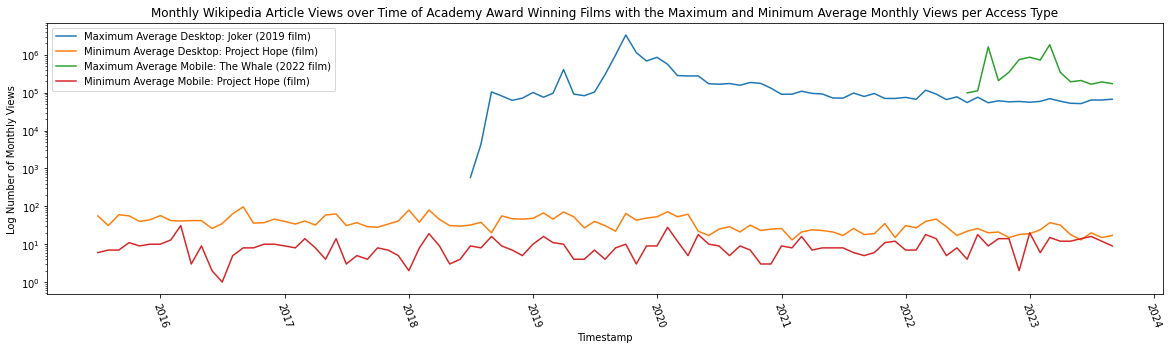

In [257]:
plt.rcParams["figure.figsize"] = (20,5)
plt.xticks(rotation=-70)
plt.plot([datetime.strptime(month["timestamp"], "%Y%m%d%H") for month in monthly_desktop[max_avg_desktop[0]]], [month["views"] for month in monthly_desktop[max_avg_desktop[0]]], label="Maximum Average Desktop: " + max_avg_desktop[0])
plt.plot([datetime.strptime(month["timestamp"], "%Y%m%d%H") for month in monthly_desktop[min_avg_desktop[0]]], [month["views"] for month in monthly_desktop[min_avg_desktop[0]]], label="Minimum Average Desktop: " + min_avg_desktop[0])
plt.plot([datetime.strptime(month["timestamp"], "%Y%m%d%H") for month in monthly_mobile[max_avg_mobile[0]]], [month["views"] for month in monthly_mobile[max_avg_mobile[0]]], label="Maximum Average Mobile: " + max_avg_mobile[0])
plt.plot([datetime.strptime(month["timestamp"], "%Y%m%d%H") for month in monthly_mobile[min_avg_mobile[0]]], [month["views"] for month in monthly_mobile[min_avg_mobile[0]]], label="Minimum Average Mobile: " + min_avg_mobile[0])
plt.yscale("log")
plt.legend()
plt.ylabel("Log Number of Monthly Views")
plt.xlabel("Timestamp")
plt.title("Monthly Wikipedia Article Views over Time of Academy Award Winning Films with the Maximum and Minimum Average Monthly Views per Access Type")
plt.savefig("max_and_min_average.png")
plt.show()

## Top 10 Peak Page Views

To get the 10 articles with the highest peak page views per access type, I made a dictionary of the high peak page views per article per access type, sorted the dictionaries by descending value, and saved the article titles of the 10 highest peak page views.

In [214]:
peak_views_mobile = {}
peak_views_desktop = {}
for article_title in monthly_mobile.keys():
    peak_views_mobile[article_title] = max(month["views"] for month in monthly_mobile[article_title])
    peak_views_desktop[article_title] = max(month["views"] for month in monthly_desktop[article_title])

In [220]:
top_10_mobile = sorted(peak_views_mobile, key=peak_views_mobile.get, reverse=True)[:10]
top_10_desktop = sorted(peak_views_desktop, key=peak_views_desktop.get, reverse=True)[:10]

To visualize the time series, I convert the timestamps to datetimes for x coordinates and views as the y coordinates for each of the 10 articles with peak page views per access type. I then specify axis labels and a correct y-axis scale to view all of the data. Without the log scale, pages with a low number of monthly views are overlapping lines at the bottom of the visual.

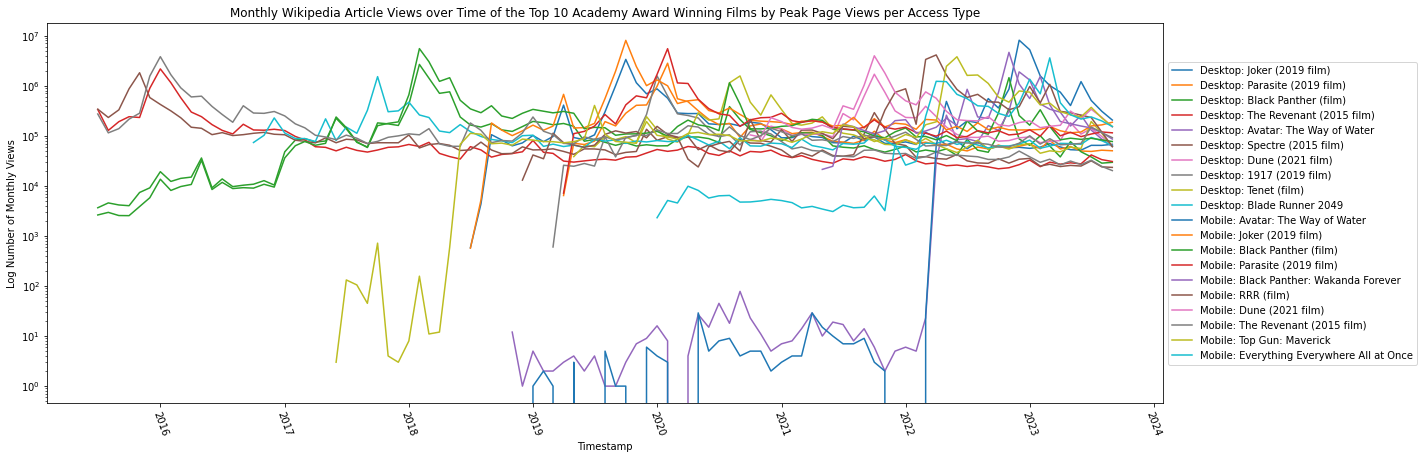

In [258]:
plt.rcParams["figure.figsize"] = (20,7)
plt.xticks(rotation=-70)
for article_title in top_10_desktop:
    plt.plot([datetime.strptime(month["timestamp"], "%Y%m%d%H") for month in monthly_desktop[article_title]], [month["views"] for month in monthly_desktop[article_title]], label="Desktop: " + article_title)
for article_title in top_10_mobile:
    plt.plot([datetime.strptime(month["timestamp"], "%Y%m%d%H") for month in monthly_mobile[article_title]], [month["views"] for month in monthly_mobile[article_title]], label="Mobile: " + article_title)
plt.legend(loc = 6, bbox_to_anchor=(1, 0.5))
plt.yscale("log")
plt.ylabel("Log Number of Monthly Views")
plt.xlabel("Timestamp")
plt.title("Monthly Wikipedia Article Views over Time of the Top 10 Academy Award Winning Films by Peak Page Views per Access Type")
plt.savefig("top10_peak_page_views.png", bbox_inches='tight')
plt.show()

## Fewest Months of Data

To get the 10 articles with the fewest months of data per access type, I made a dictionary of the number of months (the length of the time series returned by the API) per article per access type, sorted the dictionaries by ascending value, and saved the article titles of the 10 fewest months of data.

In [246]:
num_months_mobile = {}
num_months_desktop = {}
for article_title in monthly_mobile.keys():
    num_months_mobile[article_title] = len(monthly_mobile[article_title])
    num_months_desktop[article_title] = len(monthly_desktop[article_title])
recent_10_mobile = sorted(num_months_mobile, key=num_months_mobile.get)[:10]
recent_10_desktop = sorted(num_months_desktop, key=num_months_desktop.get)[:10]

To visualize the time series, I convert the timestamps to datetimes for x coordinates and views as the y coordinates for each of the 10 articles with the fewest months of data per access type. I then specify axis labels and a correct y-axis scale to view all of the data. Without the log scale, pages with a low number of monthly views are overlapping lines at the bottom of the visual.

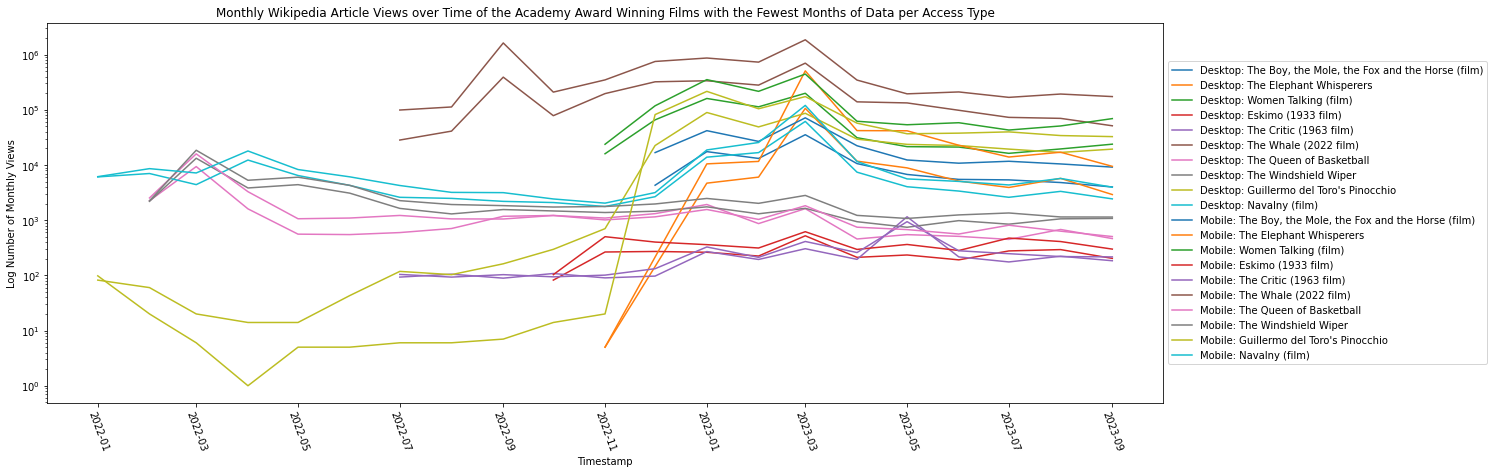

In [259]:
plt.rcParams["figure.figsize"] = (20,7)
plt.xticks(rotation=-70)
for article_title in recent_10_desktop:
    plt.plot([datetime.strptime(month["timestamp"], "%Y%m%d%H") for month in monthly_desktop[article_title]], [month["views"] for month in monthly_desktop[article_title]], label="Desktop: " + article_title)
for article_title in recent_10_mobile:
    plt.plot([datetime.strptime(month["timestamp"], "%Y%m%d%H") for month in monthly_mobile[article_title]], [month["views"] for month in monthly_mobile[article_title]], label="Mobile: " + article_title)
plt.legend(loc = 6, bbox_to_anchor=(1, 0.5))
plt.yscale("log")
plt.ylabel("Log Number of Monthly Views")
plt.xlabel("Timestamp")
plt.title("Monthly Wikipedia Article Views over Time of the Academy Award Winning Films with the Fewest Months of Data per Access Type")
plt.savefig("fewest_months_of_data.png", bbox_inches='tight')
plt.show()